<a href="https://colab.research.google.com/github/YaninaK/cv-segmentation/blob/b1/notebooks/01_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Corrosion detection in steel pipes

## 1. EDA

* **The objective**:
The objective of this challenge is to train a model that have the highest possible score for the segmentation of groove defects using the provided data

In [1]:
initiate = False
if initiate:
  !git init -q
  !git clone -b b1 https://github.com/YaninaK/cv-segmentation.git -q

  from google.colab import drive
  drive.mount('/content/drive')

  !unzip -u -q /content/drive/MyDrive/ML_projects/07_CV/data/01_raw/X_train_corrected.zip -d /content/cv-segmentation/data/raw
  !unzip -u -q /content/drive/MyDrive/ML_projects/07_CV/data/01_raw/masks.zip -d /content/cv-segmentation/data/raw
  !cp /content/drive/MyDrive/ML_projects/07_CV/data/01_raw/y_train.csv -d /content/cv-segmentation/data/raw

%cd /content/cv-segmentation/notebooks

/content/cv-segmentation/notebooks


## Install Packages

In [2]:
#install packages
!pip install imutils
!pip install torchsummary

* Для воспроизводимости среды необходимые версии библиотек лучше зафиксировать, например, в файле requirements.txt
```
imutils==0.5.4
torchsummary==1.5.1
...
```


Тогда установка будет выглдеть так:

```
!pip install -r requirements.txt
```

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import imutils.paths as paths
import glob
import matplotlib.pyplot as plt
import os
from torchvision import transforms
from PIL import Image
from torch.optim import Adam
from torchsummary import summary
from tqdm import tqdm
import random
import shutil
import cv2
from scipy.ndimage import binary_fill_holes
import pandas as pd
from pathlib import Path

In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

* Импорт лучше упорядочить по алфавиту с разделением на секции и по типам, например, как это делает библиотека [isort](https://pycqa.github.io/isort/).
Это позволит избежать повторений как, например ```from tqdm import tqdm```, ```import random``` и т.п.

Тогда иморт выглядел бы так:


```
import glob
import os
import random
import shutil
from pathlib import Path

import cv2
import imutils.paths as paths
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from scipy.ndimage import binary_fill_holes
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from torchvision import transforms
from tqdm import tqdm
```

## Look at the data


* Блок Look at the data (EDA) лучше делать в отдельном ноутбуке и давать на него ссылку

In [5]:
# Read file
y_train=pd.read_csv('../data/raw/y_train.csv',index_col=0) #Table with index being the name of the patch
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9674 entries, well_10_patch_0 to well_15_patch_99
Columns: 1296 entries, 0 to 1295
dtypes: int64(1296)
memory usage: 95.7+ MB


In [6]:
display(y_train.head())

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
well_10_patch_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* ```display``` - избыточный код. Здесь достаточно ```y_train.head()```:

In [7]:
y_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
well_10_patch_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_10_patch_12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
dict_wells_masks = {}


for name_patch in y_train.index:
    if (int(name_patch[5:7].replace('_', '')) in dict_wells_masks.keys()):
        dict_wells_masks[int(name_patch[5:7].replace('_', ''))] += 1

    else:
        dict_wells_masks[int(name_patch[5:7].replace('_', ''))]  = 1


for key in dict(sorted(dict_wells_masks.items())).keys():
    print('Well :',key, 'Number of patches :', dict_wells_masks[key])

print('Total number of wells :',len(dict_wells_masks.keys()))
print('Total number of patches :', sum(dict_wells_masks.values()))

# First well and 450 first images of well 1 are false

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203
Total number of wells : 15
Total number of patches : 9674


In [9]:
folder_path = '../data/raw/images'
file_names = os.listdir(folder_path)

dict_wells_images = {}


for name_patch in file_names:
    if (int(name_patch[5:7].replace('_', '')) in dict_wells_images.keys()):
        dict_wells_images[int(name_patch[5:7].replace('_', ''))] += 1

    else:
        dict_wells_images[int(name_patch[5:7].replace('_', ''))]  = 1


for key in dict(sorted(dict_wells_images.items())).keys():
    print('Well :',key, 'Number of patches :', dict_wells_images[key])

print('Total number of wells :',len(dict_wells_images.keys()))
print('Total number of patches :', sum(dict_wells_images.values()))

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203
Total number of wells : 15
Total number of patches : 9674


* Здесь лучше использовать Counter.
* Использовать трижды код ```int(name_patch[5:7].replace('_', ''))``` неэффективно.
* Для вывода результата лучше использовать f-strings:
```
f'Well : {key} Number of patches : {dict_wells_masks[key]}'
```
* Totals для наглядности имеет смысл отделить строкой с помощью ```\n```:
```
f'\nTotal number of wells : {len(dict_wells_masks)}'
```

Поскольку код используется неоднократно, лучше его оформить в виде формулы:

In [10]:
from collections import Counter

def get_patches_per_well(patches_list):
  patch_names = [int(name_patch.split("_")[1]) for name_patch in patches_list]
  dict_wells_patches = Counter(patch_names)

  for key in sorted(dict_wells_patches.keys()):
    print(f'Well : {key} Number of patches : {dict_wells_patches[key]}')

  print(f'\nTotal number of wells : {len(dict_wells_patches)}')
  print(f'Total number of patches :', sum(dict_wells_patches.values()))

  return dict_wells_patches

In [11]:
dict_wells_masks = get_patches_per_well(y_train.index)

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203

Total number of wells : 15
Total number of patches : 9674


In [12]:
folder_path = '../data/raw/images'
file_names = os.listdir(folder_path)
dict_wells_images = get_patches_per_well(file_names)

Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203

Total number of wells : 15
Total number of patches : 9674


In [13]:
y_keys = dict(sorted(dict_wells_masks.items())).keys()
image_keys = dict(sorted(dict_wells_images.items())).keys()

for i, key in enumerate(y_keys):
    print('Mask well :',key, 'Number of patches :', dict_wells_masks[key])
    if i == 15:
        break
    print('Image well :',list(image_keys)[i], 'Number of patches :', dict_wells_images[list(image_keys)[i]],'\n')

Mask well : 1 Number of patches : 166
Image well : 1 Number of patches : 166 

Mask well : 2 Number of patches : 616
Image well : 2 Number of patches : 616 

Mask well : 3 Number of patches : 1774
Image well : 3 Number of patches : 1774 

Mask well : 4 Number of patches : 59
Image well : 4 Number of patches : 59 

Mask well : 5 Number of patches : 98
Image well : 5 Number of patches : 98 

Mask well : 6 Number of patches : 964
Image well : 6 Number of patches : 964 

Mask well : 7 Number of patches : 1654
Image well : 7 Number of patches : 1654 

Mask well : 8 Number of patches : 78
Image well : 8 Number of patches : 78 

Mask well : 9 Number of patches : 166
Image well : 9 Number of patches : 166 

Mask well : 10 Number of patches : 80
Image well : 10 Number of patches : 80 

Mask well : 11 Number of patches : 1512
Image well : 11 Number of patches : 1512 

Mask well : 12 Number of patches : 44
Image well : 12 Number of patches : 44 

Mask well : 13 Number of patches : 1905
Image well

Для того чтобы убедиться, что число patches у Mask well и Image well совпадают, лучше использовать ```assert```:

In [14]:
for y_key in sorted(dict_wells_masks.keys()):
  assert dict_wells_masks[y_key] == dict_wells_images[y_key]

* ```dict(sorted(dict_wells_masks.items())).keys()``` - неудачная конструкция;
достаточно ```dict_wells_masks.keys()```
* Использование
```
if i == 15:
    break
```
избыточно - у нас всего 15 скважин, цикл остановится и без break.
Соответственно, избыточно использовать ```enumerate```.

### Imbalance analysis

In [15]:
n_patches = 0
n_pixels = 0
overall = 0
for row in y_train.iterrows():

    psum = np.sum(row[1])
    if psum > 0:
        n_patches += 1
        n_pixels += psum
    overall += len(row[1])

In [16]:
print('Number of patches with corrosion :', n_patches)
print('Number of pixels with corrosion :', n_pixels)
print('Overall number of pixels :', overall)
print('Ratio of pixels with corrosion :', round(n_pixels*100/overall, ndigits= 3),'%')
print('Ratio of patches with corrosion :', round(n_patches*100/len(y_train), ndigits=3),'%')

Number of patches with corrosion : 7674
Number of pixels with corrosion : 896993
Overall number of pixels : 12537504
Ratio of pixels with corrosion : 7.154 %
Ratio of patches with corrosion : 79.326 %


* Эффективнее было бы посчитать так:

In [17]:
n_patches = (y_train.sum(axis=1) > 0).sum()
n_pixels = y_train.sum(axis=1).sum()
overall = y_train.shape[0] * y_train.shape[1]

* Код последних двух строк избыточен. Лучше сделать так:

In [18]:
print(f'Ratio of pixels with corrosion : {n_pixels*100/overall: .3f} %')
print(f'Ratio of patches with corrosion : {n_patches*100/len(y_train): .3f} %')

Ratio of pixels with corrosion :  7.154 %
Ratio of patches with corrosion :  79.326 %


* Имеет смысл сделать ```Imbalance analysis``` в разрезе скважин:

In [19]:
well_ref = y_train.reset_index()["index"].apply(lambda x: int(x.split("_")[1])).tolist()

masks_frame = y_train.copy()
masks_frame["n_patches"] = y_train.sum(axis=1) > 0
masks_frame["n_pixels"] = masks_frame.sum(axis=1)
masks_frame["well"] = well_ref

n_patches = masks_frame.groupby("well")['n_patches'].sum()
n_pixels = masks_frame.groupby("well")['n_pixels'].sum()
overall = masks_frame.groupby("well").agg(overall = ("well", "count")) * y_train.shape[1]
count = masks_frame["well"].value_counts()
well_info = pd.concat([n_patches, n_pixels, overall, count], axis=1)

well_info["pixels with corrosion"] = well_info["n_pixels"] / well_info["overall"]
well_info["patches with corrosion"] = well_info["n_patches"] / well_info["count"]

well_info

,n_patches,n_pixels,overall,count,pixels with corrosion,patches with corrosion
well,,,,,,
1,130,11116,215136,166,0.05167,0.783133
2,580,50541,798336,616,0.063308,0.941558
3,1611,234831,2299104,1774,0.10214,0.908117
4,53,5139,76464,59,0.067208,0.898305
5,24,1968,127008,98,0.015495,0.244898
6,496,70235,1249344,964,0.056218,0.514523
7,1420,105092,2143584,1654,0.049026,0.858525
8,30,1678,101088,78,0.016599,0.384615
9,0,0,215136,166,0.0,0.000000


* Данные в разрезе скважин существенно отличаются по доле пикселей с коррозией. Это необходимо учитывать при составлении обучающей и валидационной/ тестовой выборок. По 9 и 10 скважинам данных по коррозии нет.

### Preprocessing analysis

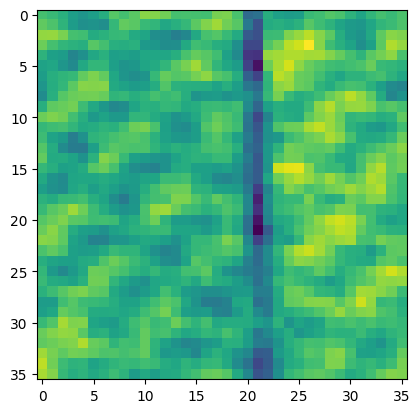

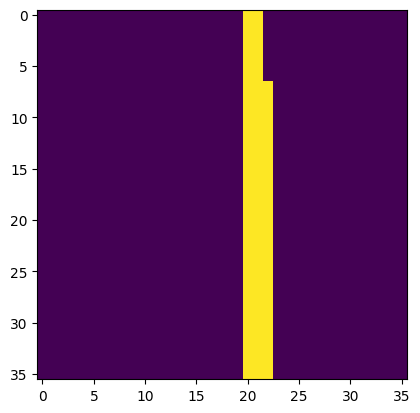

In [20]:
image = np.load('../data/raw/images/well_2_patch_3.npy')
plt.imshow(image)
plt.show()

mask = np.array(y_train.loc['well_2_patch_3']).reshape(36,36)
plt.imshow(mask)
plt.show()

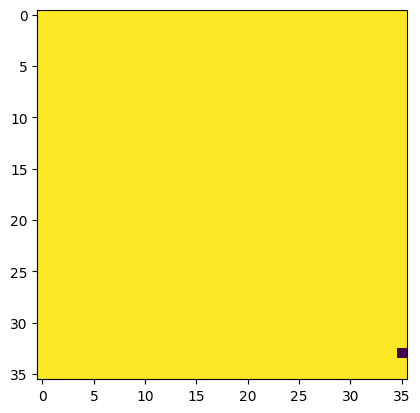

In [21]:
# Data analysis
file_names = os.listdir('../data/raw/images/')
images = []
for img_name in file_names:
    img = np.load(os.path.join('../data/raw/images/', img_name))

    if np.sum(img < -800) > 0:
        plt.imshow(img)
        plt.show()
        break

    images.append(img)

In [22]:
np.min(img), np.max(img), np.unique(img),

(-999.0,
 0.12597495,
 array([-9.9900000e+02, -9.8251313e-02, -9.6741639e-02, ...,
         3.1477571e-02,  1.0009367e-01,  1.2597495e-01], dtype=float32))

In [23]:
 # Data analysis
file_names = os.listdir('../data/raw/images/')
images_train = []
count_outliers = 0
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('../data/raw/images/', img_name))
    if img.min() < -100:
        count_outliers += 1

    images_train.append(img)
flat_list_img_train = np.array(images_train).flatten()
print('Number patches train set:', len(images_train))
print('Number of outliers:', count_outliers*100/len(file_names))

100%|██████████| 9674/9674 [00:03<00:00, 2812.85it/s]


Number patches train set: 9674
Number of outliers: 3.514575149886293


* В Number of outliers речь о доле выбросов в процентах, а не о числе выбросов

In [24]:
# Statistics on the train images

cleaned_img = np.nan_to_num(flat_list_img_train)
print('For the training images :')
print('Mean :',np.mean(cleaned_img))
print('Std :',np.std(cleaned_img))
print('Max :',np.max(cleaned_img))
print('Min :',np.min(cleaned_img))

For the training images :
Mean : -4.6509695
Std : 68.01109
Max : 0.4703434
Min : -999.25


* Статистика по квантилям была бы более информативна:

In [25]:
with np.printoptions(precision=3, suppress=True):
    print(np.quantile(cleaned_img, [0.0025, 0.005, 0.25, 0.5, 0.75, 0.995]))

[-999.25    -0.151   -0.008    0.001    0.01     0.04 ]


100%|██████████| 9674/9674 [00:05<00:00, 1848.68it/s]


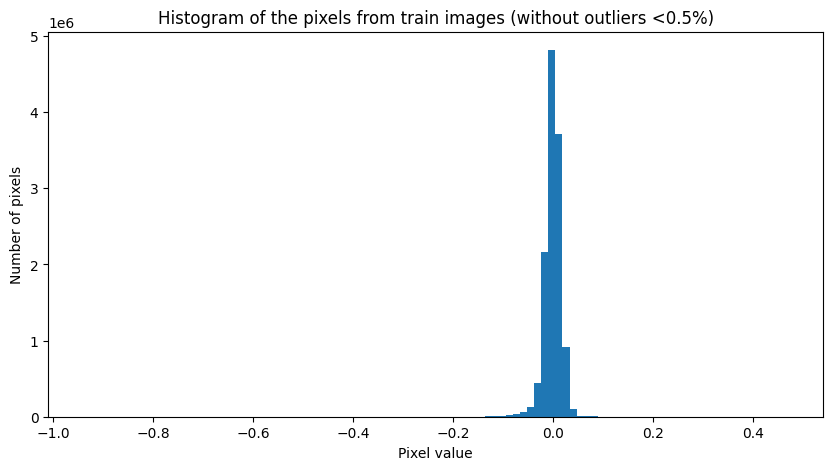

Ratio outliers pixels: 0.465 %


In [26]:
file_names = os.listdir('../data/raw/images/')
images_train = []
count_outliers = 0
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('../data/raw/images/', img_name))
    if img.min() < -100:
        count_outliers += 1

    images_train.append(img)
flat_list_img_train = np.array(images_train).flatten()
cleaned_img = np.nan_to_num(flat_list_img_train)
plt.figure(figsize=(10, 5))
plt.hist(cleaned_img[cleaned_img > -100] , bins=100)
plt.title('Histogram of the pixels from train images (without outliers <0.5%)')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.show()
print('Ratio outliers pixels:',round(len(cleaned_img[cleaned_img <-100])*100/len(cleaned_img),ndigits=3),'%')

* здесь лучше убрать дублирование кода:
```
file_names = os.listdir('../data/raw/images/')
images_train = []
count_outliers = 0
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('../data/raw/images/', img_name))
    if img.min() < -100:
        count_outliers += 1

    images_train.append(img)
flat_list_img_train = np.array(images_train).flatten()
cleaned_img = np.nan_to_num(flat_list_img_train)
```
и оставить только
```
plt.figure(figsize=(10, 5))
plt.hist(cleaned_img[cleaned_img > -100] , bins=100)
plt.title('Histogram of the pixels from train images (without outliers <0.5%)')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.show()
print('Ratio outliers pixels:',round(len(cleaned_img[cleaned_img <-100])*100/len(cleaned_img),ndigits=3),'%')
```
* Анализировать информацию по всем точкам ```flat_list_img_train``` не информативно. Лучше анализировать в разрезе изображений:

* Пропуски

In [27]:
root_dir = "/content/cv-segmentation/data/raw/images/"

images_train = []
for index in tqdm(y_train.index):
  img = np.load(os.path.join(root_dir, f"{index}.npy"))
  images_train.append(img)

100%|██████████| 9674/9674 [00:03<00:00, 2761.77it/s]


In [28]:
image_arr = np.reshape(np.asarray(images_train), (len(images_train), -1))
image_frame = pd.DataFrame(image_arr, y_train.index)

a = image_frame.isnull().sum(axis=1)
a[a > 0]

,0
well_15_patch_201,11
well_15_patch_202,683


У нас всего 2 изображения с пропусками:
* ```well_15_patch_202``` лучше удалить,
* пропуски в ```well_15_patch_201``` можно заполнить медианой этого изображения.

In [29]:
to_delete = ['well_15_patch_202']
image_frame.loc["well_15_patch_201"] = (
    image_frame.loc["well_15_patch_201"].fillna(image_frame.median(axis=1))
)

* Выбросы

Порогом отсечения выбросов слева будем считать -0.25

In [30]:
threshold = -0.25

In [31]:
image_frame_anomaly = (image_frame.iloc[:, :-1] < threshold).sum(axis=1)
image_frame_anomaly[image_frame_anomaly > 0]

,0
well_10_patch_0,72
well_10_patch_1,72
well_10_patch_18,3
well_10_patch_19,1
well_10_patch_26,1
...,...
well_9_patch_8,1295
well_9_patch_9,1295
well_13_patch_161,2
well_13_patch_493,1


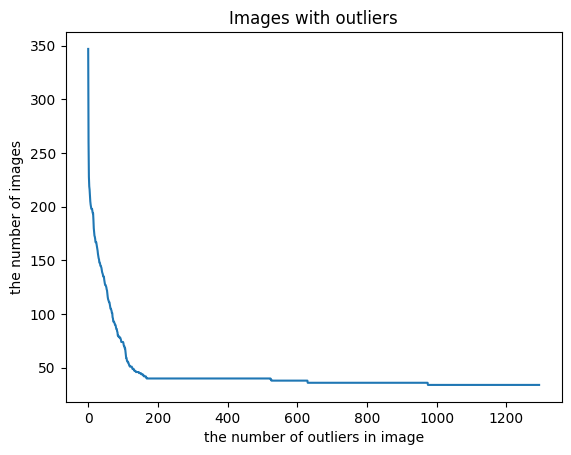


Число изображений с выбросами: 347
Число изображений с 1-2 выбросами: 119
Число изображений с менее, чем 15 выбросами: 159
Число изображений, содержащий больше 200 выбросов: 40
Число полностью поврежденных изображений: 34


In [32]:
cum_outliers = [(image_frame_anomaly > i).sum() for i in np.arange(1295)]

plt.plot(cum_outliers)
plt.title('Images with outliers')
plt.xlabel('the number of outliers in image')
plt.ylabel('the number of images')
plt.show()

print(f"\nЧисло изображений с выбросами: {cum_outliers[0]}")
print(f"Число изображений с 1-2 выбросами: {cum_outliers[0] - cum_outliers[2]}")
print(f"Число изображений с менее, чем 15 выбросами: {cum_outliers[0] - cum_outliers[15]}")
print(f"Число изображений, содержащий больше 200 выбросов: {cum_outliers[200]}")
print(f"Число полностью поврежденных изображений: {cum_outliers[-1]}")

Из 347 изображений с выбросами:
* у трети (119) поврежденны 1-2 пикселя;
* почти у половины (159) из 1296 пикселей повреждены меньше 15;
* только 40 изображений содержат больше 200 выбросов, из них 34 полностью повреждены - их можно удалить.

У остальных выбросы можно заполнить медианным значением.

In [33]:
to_delete += image_frame_anomaly[image_frame_anomaly >= 200].index.tolist()

In [34]:
idx = [i for i in image_frame.index if i not in to_delete]
df = image_frame.loc[idx]
image_frame_cleaned = df.mask(df < threshold, df.median(axis=1), axis=0)

assert (image_frame_cleaned < threshold).sum().sum() == 0

image_frame_cleaned

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
well_10_patch_0,-0.000412,-0.000412,-0.000412,-0.000412,-0.000412,-0.000412,-0.000412,-0.000412,-0.000412,-0.000412,...,0.017024,0.016007,0.015039,0.012637,-0.003598,0.001333,-0.002174,-0.015750,-0.016489,-0.010847
well_10_patch_1,-0.000806,-0.000806,-0.000806,-0.000806,-0.000806,-0.000806,-0.000806,-0.000806,-0.000806,-0.000806,...,0.014312,0.010064,0.009222,-0.002185,-0.001853,0.000917,-0.010090,-0.017946,-0.012724,-0.008150
well_10_patch_10,-0.002979,-0.004271,-0.005818,-0.005832,0.001039,0.005100,0.007400,0.002055,-0.002632,-0.002859,...,-0.003153,-0.014746,-0.011752,-0.015686,-0.017799,-0.020349,-0.019228,0.003017,0.006789,0.004101
well_10_patch_11,-0.005269,-0.004466,-0.006988,-0.002586,0.003652,0.006364,0.005641,-0.001116,-0.002329,-0.001440,...,-0.009542,-0.015098,-0.011299,-0.016271,-0.020786,-0.019643,-0.010636,0.003672,0.005662,-0.001582
well_10_patch_12,-0.002398,-0.006441,-0.006727,-0.001634,0.001214,0.001686,-0.007389,-0.011920,-0.015679,-0.009842,...,-0.009146,-0.005687,-0.010271,-0.013969,-0.015683,-0.013081,0.009609,0.010909,0.009784,0.006019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
well_15_patch_95,0.013587,0.010484,0.004901,0.005401,0.001618,-0.002305,-0.006864,-0.005063,-0.007770,-0.005627,...,0.012775,0.017945,0.019705,0.020901,0.023180,0.026395,0.023254,0.018903,0.015142,0.010999
well_15_patch_96,0.008314,0.003192,0.002544,-0.000044,-0.002885,-0.006004,-0.013668,-0.005930,-0.011954,-0.006626,...,0.013687,0.016355,0.016976,0.017689,0.016362,0.016906,0.013601,0.008005,0.004740,0.000551
well_15_patch_97,-0.006141,-0.004707,-0.003163,-0.003406,-0.005355,-0.010469,-0.009236,-0.009228,-0.007228,-0.005192,...,0.008466,0.006963,0.011139,0.007176,0.006689,0.006253,0.005782,0.003756,0.001664,-0.001943
well_15_patch_98,-0.008180,-0.005605,-0.003797,-0.002707,-0.002596,-0.004241,-0.005544,-0.003244,-0.001192,0.002914,...,0.002424,0.006420,0.010175,0.007500,0.008585,0.010286,0.008796,0.006398,0.004714,-0.012174


* Выбросы в многомерном пространстве

Для обнаружения выбосов в многомерном пространстве воспользуемся библиотекой pca - [здесь](https://erdogant.github.io/pca/pages/html/Outlier%20detection.html) cсылка

In [35]:
!pip install pca -q

In [36]:
from pca import pca

model = pca(alpha=0.05, detect_outliers=['ht2', 'spe'])
results = model.fit_transform(image_frame_cleaned.fillna(0))

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [1296] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [565] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [1296] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[565]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


In [37]:
results['outliers'].head()

,y_proba,p_raw,y_score,y_bool,y_bool_spe,y_score_spe
well_10_patch_0,1.000000e+00,1.000000e+00,498.242413,False,False,0.092055
well_10_patch_1,1.000000e+00,1.000000e+00,384.761513,False,False,0.129122
well_10_patch_10,1.000000e+00,1.000000e+00,510.869992,False,False,0.138088
well_10_patch_11,1.000000e+00,1.000000e+00,416.562235,False,False,0.173281
well_10_patch_12,8.334976e-26,4.838491e-26,1703.707145,True,False,0.296678


Здесь есть возможность настройки порога отнесения к выбросам. Пока рассмотрим предложение из коробки - ```y_bool_spe```.

In [38]:
idx = image_frame_cleaned[results['outliers']["y_bool_spe"]].index.tolist()

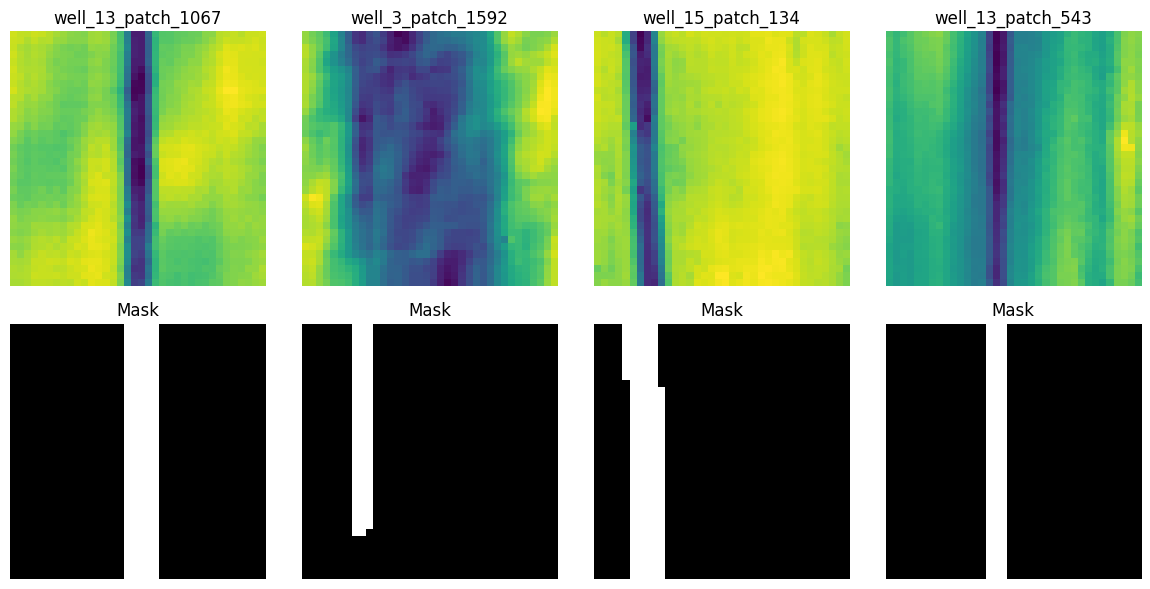

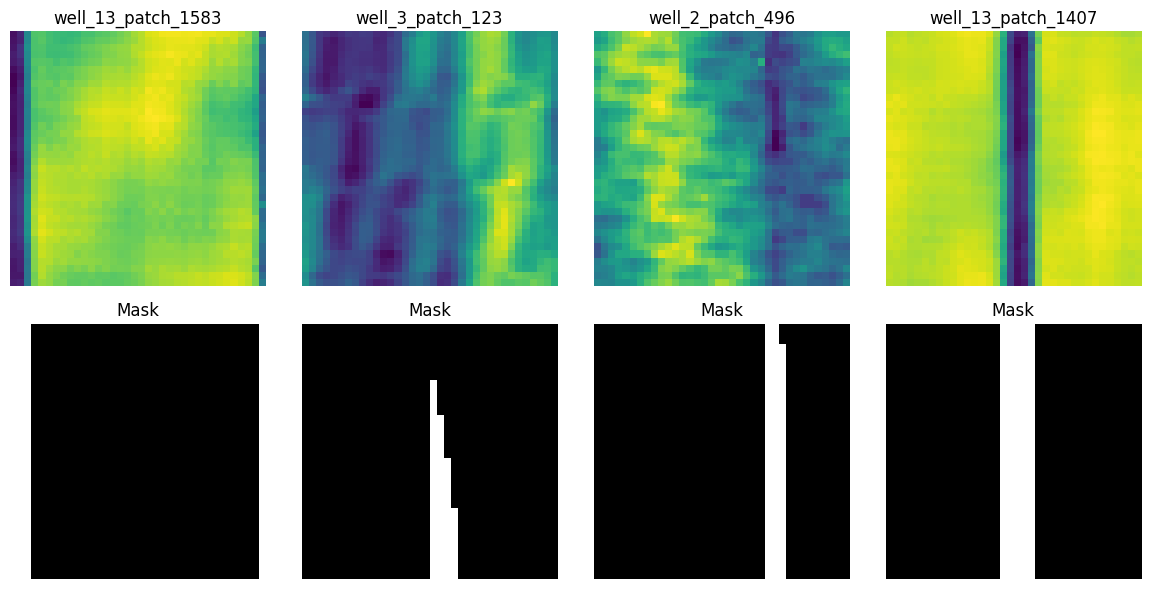

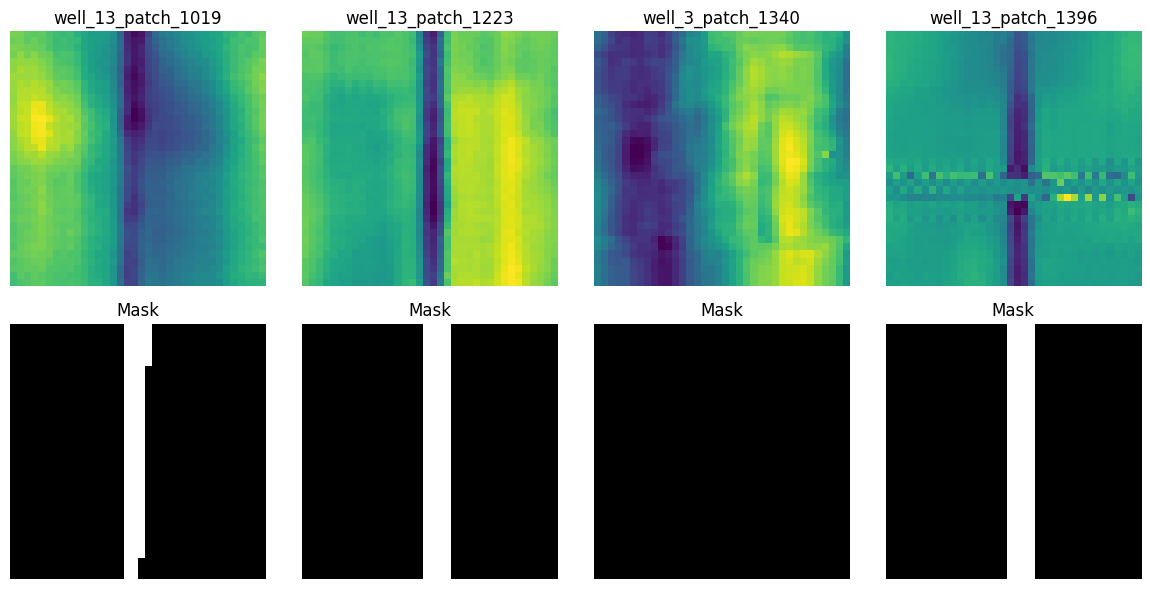

In [39]:
for n in range(3):
  fig, axes = plt.subplots(2, 4, figsize=(12, 6))

  img_name_list = random.sample(idx, 4)
  for i, img_name in enumerate(img_name_list):
      mask = np.array(y_train.loc[img_name]).reshape(36, 36)
      image = np.array(image_frame_cleaned.loc[img_name]).reshape(36, 36)

      axes[0, i].imshow(image)
      axes[0, i].set_title(img_name)
      axes[0, i].axis('off')

      axes[1, i].imshow(mask, cmap='gray')
      axes[1, i].set_title('Mask')
      axes[1, i].axis('off')

      plt.tight_layout()

  plt.show()

Для обнаружения выбросов в многомерном пространстве есть масса методов, можно попробовать другие варианты.

Изображения, отнесенные к выбросам в многомерном пространстве, имеет смысл удалить из датасета:

In [40]:
to_delete += idx
idx = [i for i in image_frame.index if i not in to_delete]
image_frame_cleaned = image_frame_cleaned.loc[idx]

In [41]:
image_frame_cleaned.shape

(9398, 1296)

* Кластеризация

In [42]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [43]:
image_clustering = DBSCAN(eps=1.5, min_samples=2).fit(image_frame_cleaned.fillna(0))
np.unique(image_clustering.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4]), array([   6, 9384,    2,    2,    2,    2]))

In [44]:
silhouette_score(
    image_frame_cleaned.fillna(0),
    image_clustering .fit_predict(image_frame_cleaned.fillna(0))
)

0.5231138

In [45]:
img_name_list = image_frame_cleaned[image_clustering.labels_ != 0].index.tolist()
img_name_list

['well_11_patch_1379',
 'well_11_patch_1509',
 'well_12_patch_12',
 'well_1_patch_80',
 'well_1_patch_81',
 'well_1_patch_82',
 'well_1_patch_83',
 'well_6_patch_926',
 'well_6_patch_927',
 'well_6_patch_942',
 'well_6_patch_943',
 'well_6_patch_960',
 'well_6_patch_961',
 'well_15_patch_201']

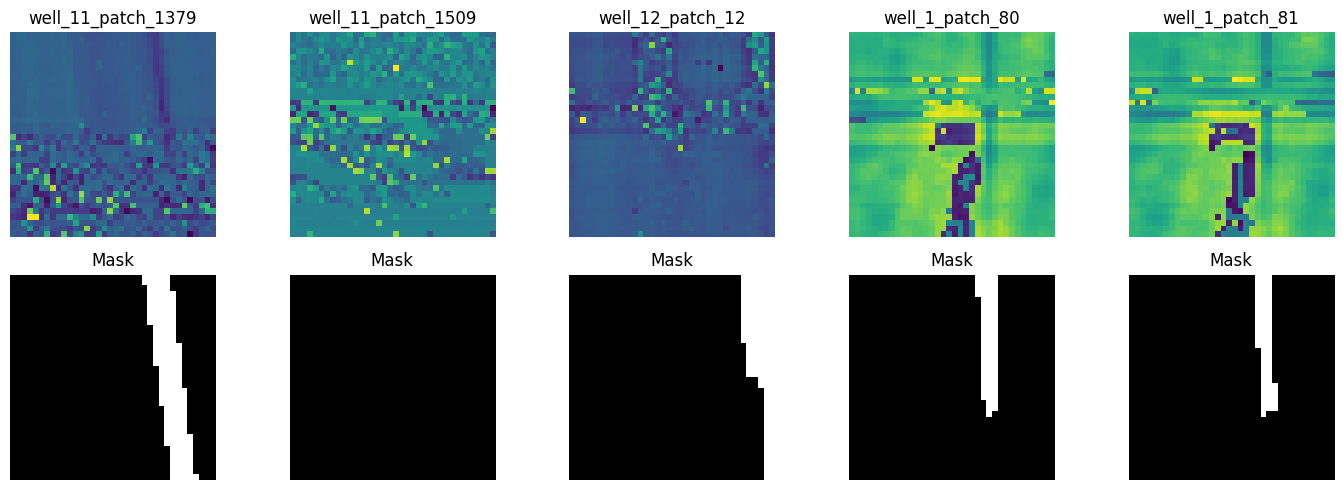

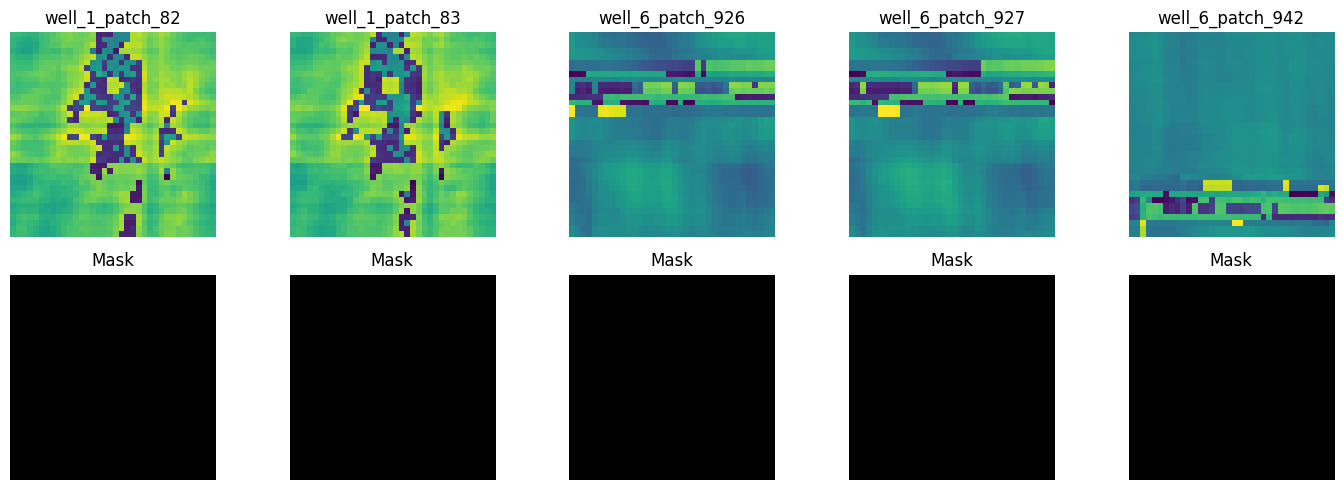

In [46]:
for n in range(2):
  fig, axes = plt.subplots(2, 5, figsize=(15, 5))
  for i, img_name in enumerate(img_name_list[5*n:5*(n+1)]):
        mask = np.array(y_train.loc[img_name]).reshape(36, 36)
        image = np.array(image_frame_cleaned.loc[img_name]).reshape(36, 36)

        axes[0, i].imshow(image)
        axes[0, i].set_title(img_name)
        axes[0, i].axis('off')

        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].set_title('Mask')
        axes[1, i].axis('off')

        plt.tight_layout()

plt.show()

Эти снимки также лучше удалить из обучaющей выборки.

In [47]:
to_delete += img_name_list
idx = [i for i in image_frame_cleaned.index if i not in to_delete]
image_frame_cleaned = image_frame_cleaned.loc[idx]

In [48]:
image_frame_cleaned.shape

(9384, 1296)

 ## Распределение скважин между обучающей, валидационной и тестовой выборкой

In [49]:
well_ref = image_frame_cleaned.reset_index()["index"].apply(lambda x: int(x.split("_")[1])).tolist()
masks_frame = y_train.loc[image_frame_cleaned.index]
masks_frame["well"] = well_ref


well_info = masks_frame.groupby("well").agg(patches_count = ("well", "count"))
well_info["mean_corrosion"] = masks_frame.groupby("well").mean().mean(axis=1)
well_info

,patches_count,mean_corrosion
well,,
1,161,0.051453
2,608,0.062704
3,1718,0.102898
4,56,0.067474
5,74,0.020270
6,940,0.056081
7,1652,0.048355
8,78,0.016303
9,154,0.000000


### Кластеризация скважин по данным снимков и разметки.

In [50]:
well_mask_frame = masks_frame.groupby("well").mean()

mask_clustering = DBSCAN(eps=6, min_samples=2).fit(well_mask_frame)
silhouette_score(well_mask_frame, mask_clustering.fit_predict(well_mask_frame))

0.44229493237184403

In [51]:
image_frame_cleaned["well"] = well_ref
well_image_frame = image_frame_cleaned.groupby("well").mean()

image_clustering = DBSCAN(eps=0.15, min_samples=2).fit(well_image_frame)
silhouette_score(well_image_frame, image_clustering .fit_predict(well_image_frame))

0.38759503

In [52]:
well_info.loc[:, "image_cluster"] = image_clustering.labels_
well_info.loc[:, "mask_cluster"] = mask_clustering.labels_

In [53]:
well_info

,patches_count,mean_corrosion,image_cluster,mask_cluster
well,,,,
1,161,0.051453,0,0
2,608,0.062704,0,0
3,1718,0.102898,0,0
4,56,0.067474,0,0
5,74,0.020270,0,0
6,940,0.056081,0,0
7,1652,0.048355,0,0
8,78,0.016303,0,0
9,154,0.000000,0,0


* 12 скважина отличается от остальных и по изображениям, и по разметке. 13 - по изображениям Поместим их в обучающую выборку.

### Распределение скважин и оценка распределения

* При распределении скважин между обучающей, валидационной и тестовой выборками, стараемся добиться более-менее сбалансированных характеристик.

In [54]:
train = [1, 6, 7, 8, 10, 11, 12, 13, 14]
val = [3, 9]
test = [2, 4, 5, 15]

In [55]:
n = len(image_frame_cleaned)
n1 = int(n * 0.7)
n2 = int(n * 0.2)
n3 = n - n1 - n2
print(n1, n2, n3)

n_train = well_info.loc[train, "patches_count"].sum()
n_val = well_info.loc[val, "patches_count"].sum()
n_test = well_info.loc[test, "patches_count"].sum()

print(n_train, n_val, n_test)
print(f"{n_train/n1: .2f} {n_val/n2: .2f} {n_test/n3: .2f}")

6568 1876 940
6593 1872 919
 1.00  1.00  0.98


In [56]:
mean_corrosion_train = well_info.loc[train, "mean_corrosion"].mean()
mean_corrosion_val = well_info.loc[val, "mean_corrosion"].mean()
mean_corrosion_test = well_info.loc[test, "mean_corrosion"].mean()

print(f"{mean_corrosion_train: .3f} {mean_corrosion_val: .3f} {mean_corrosion_test: .3f}")

 0.053  0.051  0.054


## Label Refinement

### binary fill holes

In [57]:
mask = np.array(y_train.loc['well_11_patch_1379']).reshape(36, 36)

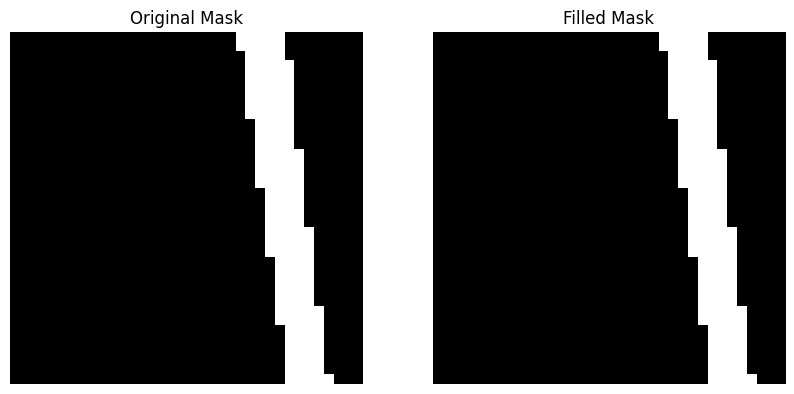

In [58]:
filled = binary_fill_holes(mask)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')

# Plot filled mask
axes[1].imshow(filled, cmap='gray')
axes[1].set_title('Filled Mask')
axes[1].axis('off')

plt.show()

### Structuring Element & Morphological Operations

In [59]:
kernel_size = (2, 2)
kernel_shape = cv2.MORPH_RECT
# Create the adaptive structuring element
adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
# Apply morphological operations : dilation
result = cv2.dilate(mask, adaptive_kernel)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')
# Plot filled mask
axes[1].imshow(result, cmap='gray')
axes[1].set_title('Dilat  Mask')
axes[1].axis('off')
plt.show()

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/morph.simd.hpp:756: error: (-213:The function/feature is not implemented) Unsupported data type (=4) in function 'getMorphologyRowFilter'


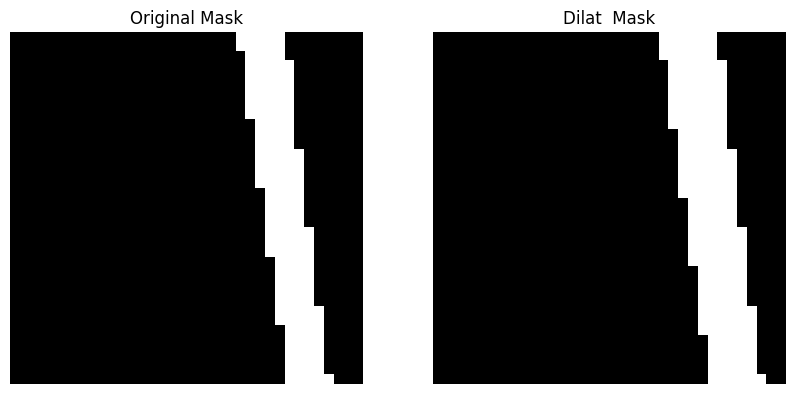

In [60]:
kernel_size = (2, 2)
kernel_shape = cv2.MORPH_RECT
# Create the adaptive structuring element
adaptive_kernel = cv2.getStructuringElement(kernel_shape, kernel_size)
# Apply morphological operations : dilation

result = cv2.dilate(np.ones((36, 36)) * mask, adaptive_kernel)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap='gray')
axes[0].set_title('Original Mask')
axes[0].axis('off')
# Plot filled mask
axes[1].imshow(result, cmap='gray')
axes[1].set_title('Dilat  Mask')
axes[1].axis('off')
plt.show()

В выражении
```
result = cv2.dilate(mask, adaptive_kernel)
```
mask должна быть в в виде 0/1, а не False/ True.

Исправленная версия выглядит так:
```
result = cv2.dilate(np.ones((36, 36)) * mask, adaptive_kernel)
```


## Image Enhancement

### CLAHE and bilateral filter

In [61]:
image = image_frame.iloc[2830, :].values.reshape((36, 36))

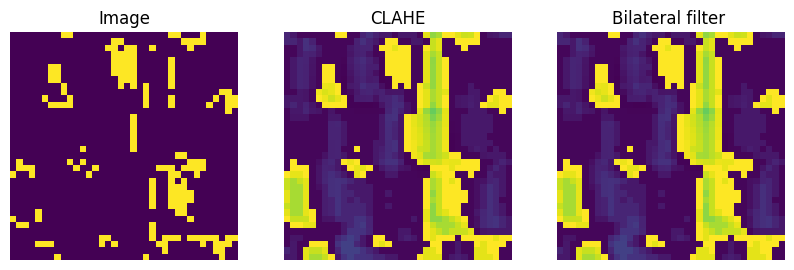

In [62]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
image = np.uint8(image * 255)

# Apply CLAHE to the grayscale image
clahe_img = clahe.apply(image)
#Apply bilateral filter
bilateral_img = cv2.bilateralFilter(clahe_img, d=2, sigmaColor=4, sigmaSpace=4)
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
# Plot Image
image = np.uint8(image /255)

axes[0].imshow(image)
axes[0].set_title('Image')
axes[0].axis('off')

#  Plot CLAHE result
axes[1].imshow(clahe_img)
axes[1].set_title('CLAHE')
axes[1].axis('off')

# Plot Bilateral filter
axes[2].imshow(clahe_img/255)
axes[2].set_title('Bilateral filter ')
axes[2].axis('off')
plt.show()

## Рекомендации

1. Блок Look at the data (EDA) лучше делать в отдельном ноутбуке и давать на него ссылку.
2. Для воспроизводимости среды необходимые версии библиотек лучше зафиксировать, например, в файле requirements.txt.
3. Импорт лучше упорядочить по алфавиту с разделением на секции и по типам, например, как это делает библиотека [isort](https://pycqa.github.io/isort/).
Это позволит избежать повторений как, например ```from tqdm import tqdm```, ```import random``` и т.п.
4. Лучше избегать избыточного кода, как, например, в ```display(y_train.head())``` - достаточно ```y_train.head()```.
5. Для генерации ```dict_wells_masks``` и ```dict_wells_images```, чтобы не дублировать код, лучше воспользоваться формулой:

```
from collections import Counter

def get_patches_per_well(patches_list):
  patch_names = [int(name_patch.split("_")[1]) for name_patch in patches_list]
  dict_wells_patches = Counter(patch_names)

  for key in sorted(dict_wells_patches.keys()):
    print(f'Well : {key} Number of patches : {dict_wells_patches[key]}')

  print(f'\nTotal number of wells : {len(dict_wells_patches)}')
  print(f'Total number of patches :', sum(dict_wells_patches.values()))

  return dict_wells_patches
```
6. Для того чтобы убедиться, что число patches у Mask well и Image well совпадают, лучше использовать ```assert```:

```
for y_key in sorted(dict_wells_masks.keys()):
  assert dict_wells_masks[y_key] == dict_wells_images[y_key]

```
7. ```dict(sorted(dict_wells_masks.items())).keys()``` - неудачная конструкция;
достаточно ```dict_wells_masks.keys()```
8. В коде

```
for i, key in enumerate(y_keys):
    print('Mask well :',key, 'Number of patches :', dict_wells_masks[key])
    if i == 15:
        break
    print('Image well :',list(image_keys)[i], 'Number of patches :', dict_wells_images[list(image_keys)[i]],'\n')
```

использование
```
if i == 15:
    break
```
избыточно - у нас всего 15 скважин, цикл остановится и без break.
Соответственно, избыточно использовать и ```enumerate```.

9. Код строк ниже избыточен:
```
print('Ratio of pixels with corrosion :', round(n_pixels*100/overall, ndigits= 3),'%')
print('Ratio of patches with corrosion :', round(n_patches*100/len(y_train), ndigits=3),'%')
```
Лучше написать так:
```
print(f'Ratio of pixels with corrosion : {n_pixels*100/overall: .3f} %')
print(f'Ratio of patches with corrosion : {n_patches*100/len(y_train): .3f} %')
```
Эти параметры лучше проанализировать в разрезе скважин - ```Ratio of pixels with corrosion``` существенно отличается межуду скважинами - у скважин 9 и 10 информации разметки по коррозиии нет.

10. В ячейке Data analysis в Number of outliers речь о доле выбросов в процентах, а не о числе выбросов - лучше написать Ratio of outliers.

11. В ячейке ```Statistics on the train images``` дополнительную информацию дала бы статистика по квантилям:

```
with np.printoptions(precision=3, suppress=True):
    print(np.quantile(cleaned_img, [0.0025, 0.005, 0.25, 0.5, 0.75, 0.995]))
```

12. В ячейке, где генерируется Histogram of the pixels from train images имеет смысл убрать дублирование кода.

13. Пропуски есть только в 2 изображениях. Почти все пропуски приходятся на один снимок, его лучше удалить. В другом 11 пропусков можно заполнить медианной этого снимка.

14. Анализировать информацию по всем точкам ```flat_list_img_train``` не информативно. Лучше смотеть по кадрам.

15. Выбросы в одномерном пространстве: из 347 изображений с выбросами (с минимальным значением меньше -0.25):

    - у трети (119) поврежденны 1-2 пикселя;
    - почти у половины (159) из 1296 пикселей повреждены меньше 15;
    - только 40 изображений содержат больше 200 выбросов, из них 34 полностью повреждены - их можно удалить.
    
  У остальных выбросы можно заполнить медианным значением.

16. Выбросы в многомерном пространстве: для обнаружения выбосов в многомерном пространстве можно воспользоваться библиотекой pca, кластеризацией DBSCAN, есть множество других методов. В обучающей выборке свыше 200 изображений - выбросы в многомерном пространстве, их лучше удалить.

17. Чтобы избежать data leakage, распределение данных между обучающей, валидационной и тестовой выборкой делаем по скважинам:
```
train = [1, 6, 7, 8, 10, 11, 12, 13, 14]
val = [3, 9]
test = [2, 4, 5, 15]
```
При распределении скважин стараемся добиться более-менее сбалансированных характеристик.

18. Материалы о Label Refinement и Image Enhancement лучше поместить в EDA.

19. Для удобства чтения хорошо использовать подзаголовки, чтобы была видна структура материла. Этого легко добиться, используя разное число знаков ```#```, например: ```#```, ```##``` или ```###```, в зависимости от уровня подзаголовка.


Рекомендации реализованы в коде этого ноутбука, код можно посмотреть выше.
